# Image segmentation

We solve the problem of medical image segmentation. We will compare two models: SegNet and U-Net.

# Prepare usful functions

---


1. First, we will download the dataset: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>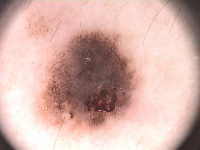</td><td>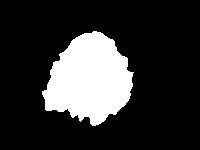</td></tr></table>

2. Unzip the .rar file.

These are photographs of two types of **skin lesions:** melanoma and moles.
In this task we will not classify them, but will **segment** them.

In [12]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar


--2023-12-19 03:36:37--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2023-12-19 03:36:38--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7c02954fedaf92a079521f99a7.dl.dropboxusercontent.com/cd/0/inline/CJofo_fAEkD_tZTaDd1Q0fF6DOhFW8rvHBhp2Kw9xo5eQfrsKEUwr_c2RJ4YU67tKmUy30lTjllxGQqN86bbk-8B6kZfQdivF2u178vkuwU_dP1egR2CrHOtE9kZEGHwxnQ/file# [following]
--2023-12-19 03:36:38--  https://uc7c02954fedaf92a079521f99a7.dl.dropboxusercontent.com/cd/0/inline/CJofo_fAEkD_tZTaDd1Q0fF6DOhFW8rvHBhp2Kw9xo5eQfrsKEUwr_c2RJ4YU67tKmUy30lTjllxGQqN86bbk-8B6kZfQdivF2u178vkuwU_dP1egR

In [13]:
!ls

PH2Dataset.rar	sample_data


In [14]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Our dataset structure is as follows:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Here `X.bmp` is the image that needs to be segmented, `X_lesion.bmp` is the result of segmentation.
To load the dataset you can use skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [15]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'
i = 0
for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

The images have different sizes. Let's resize them to $256\times256 $ pixels. To resize images you can use [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
This function also automatically normalizes images in the range [0,1].


In [16]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [17]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [18]:
len(lesions)

200

To make sure everything is correct, we will draw several images

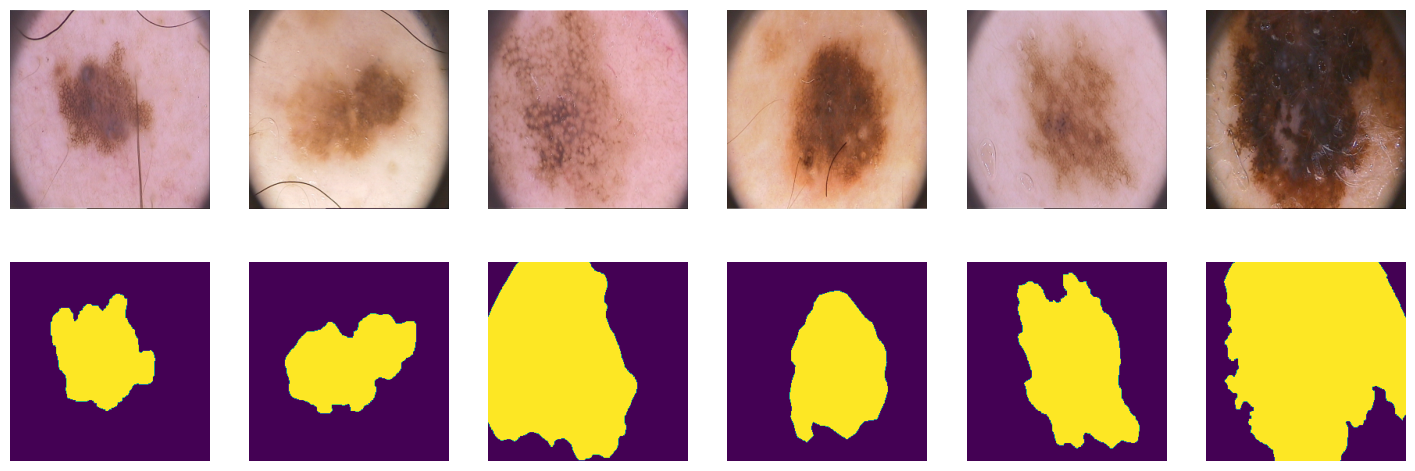

In [19]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Let's divide our 200 pictures by 100/50/50
for training, validation and test respectively

In [20]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [21]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [22]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [23]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [25]:
results = list()

## Metric

This section suggests using the following metric to assess quality:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

The intersection (A ∩ B) consists of the pixels found in both the prediction mask and the ground truth mask, whereas the union (A ∪ B) simply consists of all the pixels found in either the prediction mask or the target mask.

For example, let's look at the truth (left) and prediction (right):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)

Then the intersection and union will look like this:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [26]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    # print(outputs.shape, labels.shape, sep='\n')
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

## Loss function

No less important than the construction of the architecture is the definition of the **optimizer** and **loss function.**

The loss function is what we are trying to minimize. Many of them can be used for the task of binary semantic segmentation.

A popular method for binary segmentation is *binary cross-entropy*, which is defined as follows:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

where $y$ is the target of the desired result and $\hat y$ is the output of the model. $\sigma$ is a [*logistic* function](https://en.wikipedia.org/wiki/Sigmoid_function) that converts a real number $\mathbb R$ into a probability $[0,1]$.

However, this loss suffers from problems of numerical instability. The most important thing is that $\lim_{x\rightarrow0}\log(x)=\infty$ leads to instability in the optimization process. It is recommended to look at the following [simplification](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). This function is equivalent to the first and is not so subject to numerical instability:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [27]:
def bce_loss(y_real, y_pred):
    BCE = y_pred - y_real * y_pred +torch.log(1+torch.exp(-y_pred))
    return BCE.mean()

In [28]:
y_pred = torch.tensor([1,2,3])/sum(torch.tensor([1,2,3]))
y_real = torch.tensor([4,5,6])/sum(torch.tensor([4,5,6]))
print(bce_loss(y_pred, y_real))
loss = nn.BCEWithLogitsLoss()

output = loss(y_real, y_pred)
print(output)

tensor(0.7555)
tensor(0.7555)


## Train

We'll define the learning loop in a function so we can reuse it.

In [29]:
def score_model(model, metric, data, treshold=0.5):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
      for X_batch, Y_label in data:
          Y_pred = torch.sigmoid(model(X_batch.to(device)))
          Y_pred = torch.where(Y_pred > treshold, 1, 0)
          # Y_pred = model(X_batch.to(device))
          scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

In [30]:
import torch
import gc
def train(model, opt, loss_fn, epochs, data_tr, data_val, metric=iou_pytorch):
    X_val, Y_val = next(iter(data_val))
    losses = {'train': [], 'valid': []}
    scores = []
    scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=LEARNING_RATE, epochs=epochs, steps_per_epoch=len(data_tr))
    for epoch in range(epochs):

        torch.cuda.empty_cache()


        gc.collect()
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # set parameter gradients to zero

            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch, Y_pred)
            loss.backward() # backward-pass
            opt.step()  # update weights
            scheduler.step()
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        losses['train'].append(avg_loss.item())

        # show intermediate results
        model.eval()  # testing mode
        avg_loss = 0
        for X_val, Y_val in data_val:
            with torch.no_grad():
              Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu
              loss =  loss_fn(Y_val, Y_hat)
              avg_loss += loss / len(data_tr)

        losses['valid'].append(avg_loss.item())

        scores.append(score_model(model, metric, data_val))

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle(f'{epoch+1} / {epochs} - val_loss: {avg_loss:.5f}, val_metr: {scores[-1]:.5f}')
        plt.show()
    return [losses, scores]

## Inference

Once the model is trained, this function can be used to predict segmentation on new data:

In [31]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [32]:
"""Hyperparameters"""
EPOCHS = 60
LEARNING_RATE = 0.003

-----------------------------------------------------------------------------------------

# SegNet

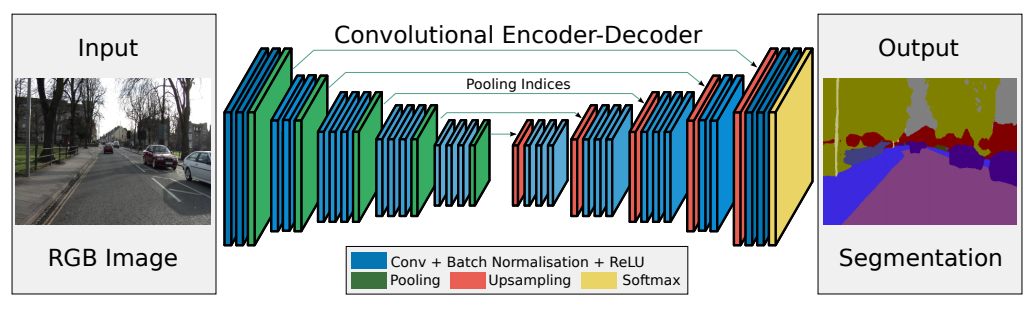

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [33]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(inplace=True),
                            nn.BatchNorm2d(64),
                         )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
                            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(inplace=True),
                            nn.BatchNorm2d(128),
                         )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(inplace=True),
                            nn.BatchNorm2d(256),
                         )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(inplace=True),
                            nn.BatchNorm2d(512),
                         )
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(inplace=True),
                            nn.BatchNorm2d(512),
                         )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear')# 16 -> 32
        self.dec_conv0 = nn.Sequential(
                            nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(inplace=True),
                            nn.BatchNorm2d(256),
                         )
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear') # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(inplace=True),
                            nn.BatchNorm2d(128),
                         )
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                            nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(inplace=True),
                            nn.BatchNorm2d(64),
                         )
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                            nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),

                            nn.BatchNorm2d(1),
                         )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 =self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

print('NAME:\tSegNet\nPARAMS:\t', sum(len(p) for p in SegNet().parameters() if p.requires_grad))

NAME:	SegNet
PARAMS:	 7684


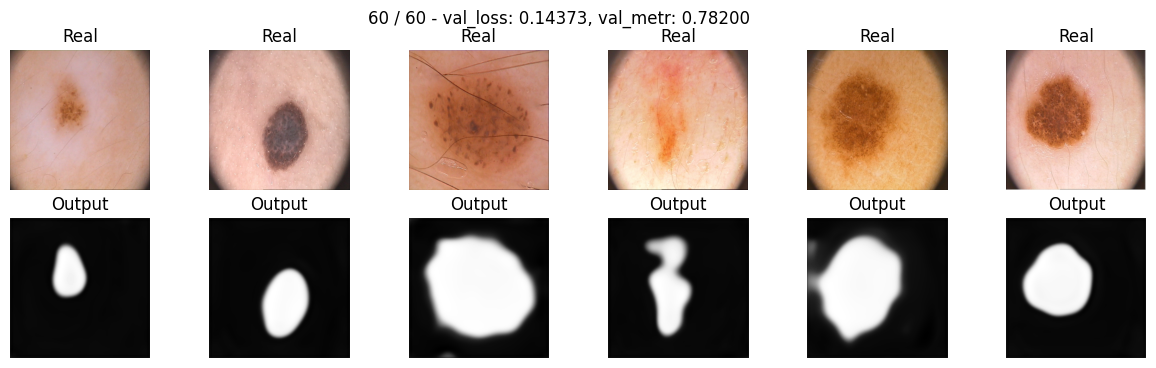

In [34]:
model_seg = SegNet().to(device)
optim = torch.optim.AdamW(model_seg.parameters(), lr=LEARNING_RATE)
res_bce, acc_bce = train(model_seg, optim, bce_loss, EPOCHS, data_tr, data_val)
results.extend(["seg", res_bce, acc_bce])

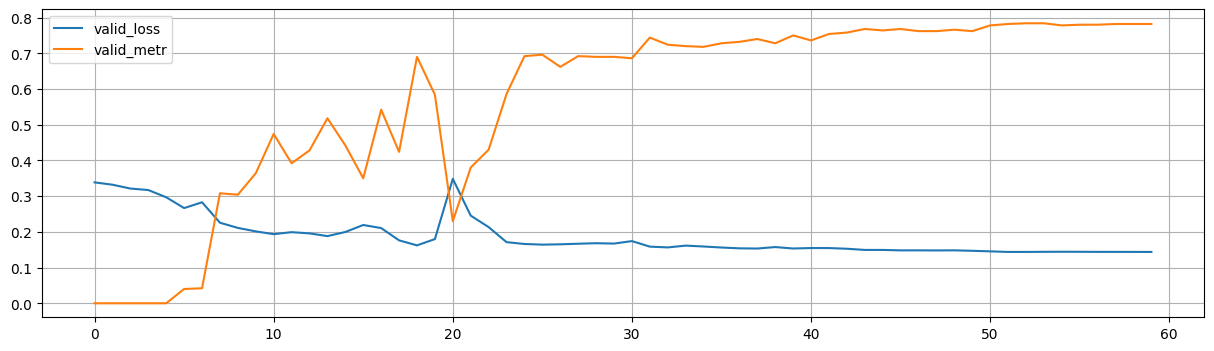

In [35]:
res, acc = res_bce, acc_bce
ep = range(len(res['train']))
# plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.legend();

In [36]:
score_model(model_seg, iou_pytorch, data_val)

0.7820000350475311

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

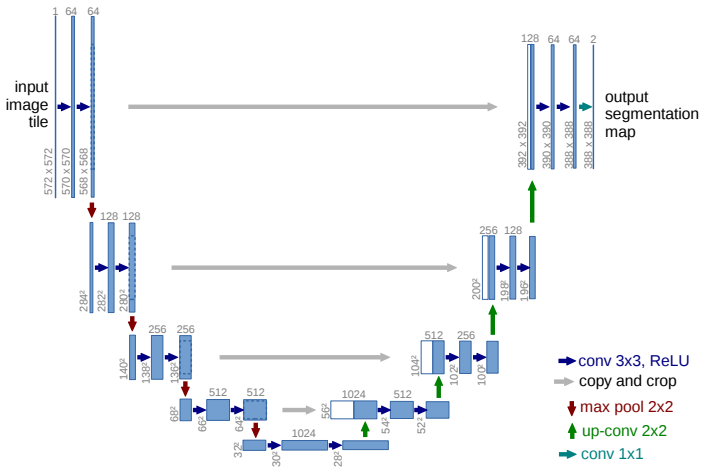

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [37]:
class OneBlock(nn.Module):
    def __init__(self, in_channels, out_channels, ker_s, st, pad):
        super(OneBlock, self).__init__()
        self.block = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=(ker_s, ker_s), stride=(st, st), padding=(pad, pad)),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(out_channels),
        )
    def forward(self, x):
      return self.block(x)

class UNet(nn.Module):  # конкатенация симметричного выхода с энкодера и выход предыдущего слоя декодера.
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
                            OneBlock(3, 64, 3, 1, 1),
                            OneBlock(64, 64, 3, 1, 1),
                            OneBlock(64, 64, 3, 1, 1)
                         ) # 25x64x256x256
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 256 -> 128 # 25x64x128x128
        self.enc_conv1 = nn.Sequential(
                            OneBlock(64, 128, 3, 1, 1),
                            OneBlock(128, 128, 3, 1, 1),
                            OneBlock(128, 128, 3, 1, 1)
                         ) # 25x128x128x128
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 128 -> 64 # 25x128x64x64
        self.enc_conv2 = nn.Sequential(
                            OneBlock(128, 256, 3, 1, 1),
                            OneBlock(256, 256, 3, 1, 1),
                            OneBlock(256, 256, 3, 1, 1)
                         ) # 25x256x64x64
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 64 -> 32 # 25x256x32x32
        self.enc_conv3 = nn.Sequential(
                            OneBlock(256, 512, 3, 1, 1),
                            OneBlock(512, 512, 3, 1, 1),
                            OneBlock(512, 512, 3, 1, 1)
                         ) # 25x512x32x32
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 32 -> 16 # 25x512x16x16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                            OneBlock(512, 512, 3, 1, 1),
                            OneBlock(512, 512, 3, 1, 1),
                            OneBlock(512, 512, 3, 1, 1),
                         ) # 25x512x16x16

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear')# 16 -> 32  # 25x512x32x32
        self.dec_conv0 = nn.Sequential(
                            OneBlock(512*2, 512, 3, 1, 1),
                            OneBlock(512, 512, 3, 1, 1),
                            OneBlock(512, 256, 3, 1, 1)
                         )   # 25x256x32x32
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear') # 32 -> 64   # 25x256x64x64
        self.dec_conv1 = nn.Sequential(
                            OneBlock(256*2, 256, 3, 1, 1),
                            OneBlock(256, 256, 3, 1, 1),
                            OneBlock(256, 128, 3, 1, 1),
                         ) # 25x128x64x64
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 64 -> 128  # 25x128x128x128
        self.dec_conv2 = nn.Sequential(
                            OneBlock(128*2, 128, 3, 1, 1),
                            OneBlock(128, 128, 3, 1, 1),
                            OneBlock(128, 64, 3, 1, 1),
                         ) # 25x64x128x128
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 128 -> 256  # 25x64x256x256
        self.dec_conv3 = nn.Sequential(
                            OneBlock(64*2, 64, 3, 1, 1),
                            OneBlock(64, 64, 3, 1, 1),
                            nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),

                            nn.BatchNorm2d(1),
                         )  # 25x1x256x256

    def forward(self, x):
        # encoder
        e0_0 = self.enc_conv0(x)

        e0 = self.pool0(e0_0)
        e1_0 = self.enc_conv1(e0)
        e1 = self.pool1(e1_0)
        e2_0 = self.enc_conv2(e1)
        e2 = self.pool2(e2_0)
        e3_0 = self.enc_conv3(e2)
        e3 =self.pool3(e3_0)
        # print('e3_0', e3_0.shape)
        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        # print('self.upsample0(b)', self.upsample0(b).shape)
        # print('torch.cat([self.upsample0(b),e3_0],1)', torch.cat([self.upsample0(b),e3_0],1).shape)
        d0 = self.dec_conv0(torch.cat([self.upsample0(b),e3_0],1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0),e2_0],1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1),e1_0],1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2),e0_0],1))  # no activation
        return d3


In [38]:
results_unet = []

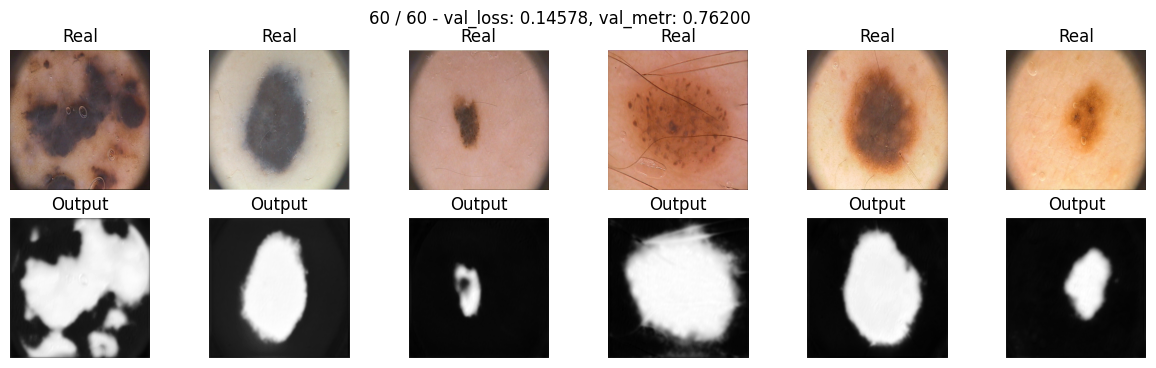

In [39]:
unet_model = UNet().to(device)
optimaizer = torch.optim.Adam(unet_model.parameters(), LEARNING_RATE)
res_bce, acc_bce = train(unet_model, optimaizer, bce_loss, EPOCHS, data_tr, data_val)
results_unet.extend(["unet", res_bce, acc_bce])

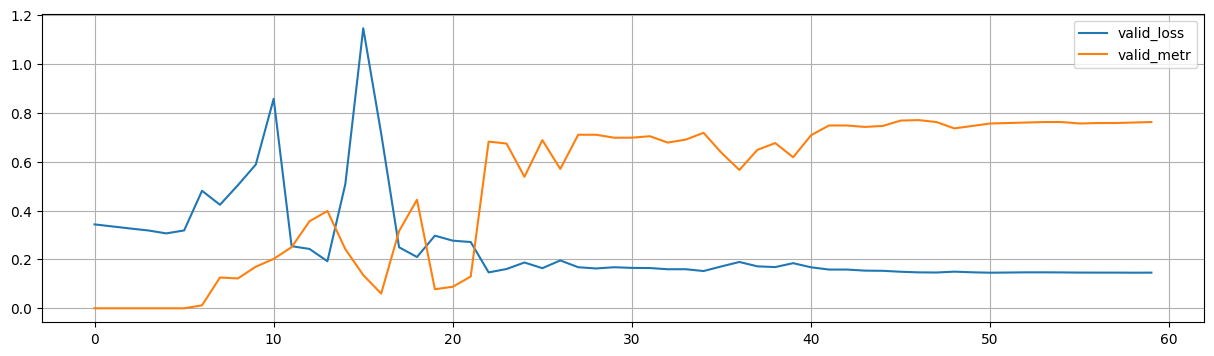

In [40]:
res, acc = res_bce, acc_bce
ep = range(len(res['train']))
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.legend();

In [41]:
score_model(unet_model, iou_pytorch, data_val)

0.7619999945163727

# Save the best model

SegNet is the best model here. We will save it:

In [43]:
torch.save(model_seg.state_dict(), 'best_model.pth')